In [1]:
from __future__ import print_function
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
#get_ipython().run_line_magic('matplotlib', 'inline')

import numpy as np
import h5py
import keras
import matplotlib.pyplot as plt
import sklearn as sk

from matplotlib.gridspec import GridSpec

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras import backend as K
from keras import losses, regularizers
from keras.models import Sequential, Model
from keras.layers import Input, RepeatVector, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate
from keras.engine.topology import Layer
from keras.layers.wrappers import TimeDistributed
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy

from tensorflow.contrib import distributions

from scipy import interp
from scipy.optimize import curve_fit

from itertools import cycle

Using TensorFlow backend.


In [2]:
input_shape = (128, 128, 1)
target_shape = (5)
epochs = 100
batch_size = 32
callback = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=0, cooldown=2),
           EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=True)]#,
           #ModelCheckpoint(filepath='spin_checkpoint-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=5)]
reg = regularizers.l2(0.0)
dropout_rate = 0.01

In [3]:
N_slice = 10
randInt = np.random.randint(100, size=N_slice)

N_T = [randInt[i] for i in range(len(randInt))]
print(N_T)
N_T = set(N_T)
N_T = list(N_T)
print(N_T)
print(len(N_T))
T_val = np.zeros(len(N_T))
for i in range(len(N_T)):
    T_val[i] = 1000-(N_T[i]*1)
print(T_val)
print(np.sort(T_val))
print(len(T_val))

[37, 12, 72, 9, 75, 5, 79, 64, 16, 1]
[64, 1, 5, 37, 72, 9, 75, 12, 79, 16]
10
[936. 999. 995. 963. 928. 991. 925. 988. 921. 984.]
[921. 925. 928. 936. 963. 984. 988. 991. 995. 999.]
10


In [4]:
def data_splitting(data):
    split = np.zeros([100000, len(T_val)])
    for i in range(len(T_val)):
        split[:,i] = K.get_value(K.equal(data['y_new'][:,3], T_val[i]))

    split = K.get_value(K.sum(split, axis=1))
    x_val = data['x_new'][(np.where((split) == 1))[0],:]
    y_val = data['y_new'][(np.where((split) == 1))[0],:]
    x_train = data['x_new'][(np.where((split) == 0))[0],:]
    y_train = data['y_new'][(np.where((split) == 0))[0],:]

    Nval = x_val.shape[0]
    return x_val, y_val, x_train, y_train, Nval

In [5]:
def labeling(y_val, y_train):
    lb = sk.preprocessing.LabelBinarizer()
    lb.fit(np.unique(y_val[:,4])*30)
    y_val_labels = lb.transform(y_val[:,4]*30)
    y_train_labels = lb.transform(y_train[:,4]*30)
    return y_val_labels, y_train_labels

In [6]:
def prediction(model, x_val, y_val_labels):
    pred = model.predict(x_val)
    pred_class = pred.argmax(axis=-1)
    a_true = y_val_labels[:]
    a_true_class = np.argmax(a_true, axis=-1)
    return pred, pred_class, a_true, a_true_class

# 690 GHz

In [40]:
data = h5py.File('dataV6_690_0.h5')
#test = h5py.File('dataV4_1_230_test.h5')

In [41]:
x_val, y_val, x_train, y_train, Nval = data_splitting(data)
y_val_labels, y_train_labels = labeling(y_val, y_train)

In [42]:
inputs = Input(input_shape)

x=Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 kernel_regularizer=reg,
                 input_shape=input_shape) (inputs)
x=MaxPooling2D(pool_size=(2, 2), padding='same') (x)
x=Dropout(dropout_rate) (x)
x=Conv2D(32, (3, 3), activation='relu', kernel_regularizer=reg) (x)
x=MaxPooling2D(pool_size=(2, 2), padding='same') (x)
x=Dropout(dropout_rate)(x)
x=Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg)(x)
x=MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#x=Dropout(dropout_rate)(x)
#x=Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg)(x)
#x=MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#x=Dropout(dropout_rate)(x)
#x=Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg)(x)
#x=MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x=Flatten()(x)
outputs=Dense(5, activation='softmax', kernel_regularizer=reg)(x) 

model = Model(inputs=inputs, outputs=outputs)

In [43]:
model.compile(loss=categorical_crossentropy,
              optimizer=keras.optimizers.adam(lr = 1e-3),
             metrics=['accuracy'])

In [44]:
history = model.fit(x_train, y_train_labels,
          batch_size=batch_size,
          shuffle="batch",
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val_labels),
          callbacks = callback)

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 30s 328us/step - loss: 1.0014 - acc: 0.5856 - val_loss: 0.4341 - val_acc: 0.8567
Epoch 2/100
90000/90000 [==============================] - 30s 335us/step - loss: 0.3207 - acc: 0.8953 - val_loss: 0.2878 - val_acc: 0.9069
Epoch 3/100
90000/90000 [==============================] - 29s 326us/step - loss: 0.2060 - acc: 0.9341 - val_loss: 0.1739 - val_acc: 0.9462
Epoch 4/100
90000/90000 [==============================] - 29s 325us/step - loss: 0.1594 - acc: 0.9485 - val_loss: 0.1693 - val_acc: 0.9439
Epoch 5/100
90000/90000 [==============================] - 29s 322us/step - loss: 0.1249 - acc: 0.9594 - val_loss: 0.1247 - val_acc: 0.9570
Epoch 6/100
90000/90000 [==============================] - 29s 319us/step - loss: 0.1090 - acc: 0.9642 - val_loss: 0.1344 - val_acc: 0.9541
Epoch 7/100
90000/90000 [==============================] - 30s 336us/step - loss: 0.0956 - acc: 0.9683 - val_l

In [45]:
#model = load_model('/home/jgucht/ML/V5/models/classification_690.h5')
score_690 = model.evaluate(x_val, y_val_labels, verbose=0)
model.save('/home/jgucht/ML/V6/models/classification_690.h5')
print('Test loss:', score_690)

Test loss: [0.06076636395966634, 0.9811]


In [46]:
pred_690, pred_class_690, a_true_690, a_true_class_690 = prediction(model, x_val, y_val_labels)

# Plotting

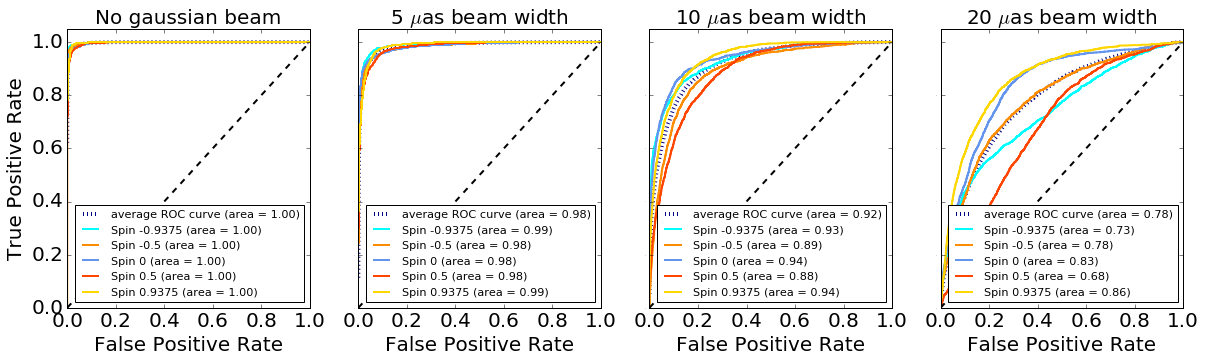

In [36]:
plt.clf()

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(1, 4)
cmap=plt.cm.Blues
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'orangered', 'gold'])
#fig.suptitle("690 GHz", y=1.05, size=20)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

classes = [-15./16, -1/2., 0 , 1/2., 15./16]

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_no_blur[:, i], pred_no_blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_no_blur.ravel(), pred_no_blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure(1)


ax1.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Spin {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set(xlim = [0.0, 1.0], ylim =[0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize = 20)
ax1.set_ylabel('True Positive Rate', fontsize = 20)
ax1.set_title('No gaussian beam', fontsize = 20)
ax1.legend(loc="lower right", fontsize = 11.25)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_5blur[:, i], pred_5blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_5blur.ravel(), pred_5blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure(1)

ax2.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Spin {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set(xlim = [0.0, 1.0], ylim =[0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize = 20)
#ax2.set_ylabel('True Positive Rate')
ax2.set_title(r'5 $\mu$as beam width', fontsize = 20)
ax2.legend(loc="lower right", fontsize = 11.25)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_10blur[:, i], pred_10blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_10blur.ravel(), pred_10blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure(1)

ax3.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    ax3.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Spin {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

ax3.plot([0, 1], [0, 1], 'k--', lw=lw)
ax3.set(xlim = [0.0, 1.0], ylim =[0.0, 1.05])
ax3.set_xlabel('False Positive Rate', fontsize = 20)
#ax3.set_ylabel('True Positive Rate')
ax3.set_title(r'10 $\mu$as beam width', fontsize = 20)
ax3.legend(loc="lower right", fontsize = 11.25)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_20blur[:, i], pred_20blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_20blur.ravel(), pred_20blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure(1)

ax4.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    ax4.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Spin {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

ax4.plot([0, 1], [0, 1], 'k--', lw=lw)
ax4.set(xlim = [0.0, 1.0], ylim =[0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize = 20)
#ax4.set_ylabel('True Positive Rate', fontsize = 30)
ax4.set_title(r'20 $\mu$as beam width', fontsize = 20)
ax4.legend(loc="lower right", fontsize = 11.25)

ax1.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax2.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax3.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax4.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)



ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax2.set_yticklabels('ytick',fontsize=0)
ax3.set_yticklabels('ytick',fontsize=0)
ax4.set_yticklabels('ytick',fontsize=0)

#plt.savefig('figures/ROC.png', bbox_inches='tight', transparent=False,pad_inches=0,dpi=100)
plt.savefig('figures/ROC.pdf', bbox_inches='tight', transparent=False,pad_inches=0,dpi=20)
plt.show()

In [ ]:
plt.clf()

fig = plt.figure(figsize=(5, 5))
gs = GridSpec(1, 1)
cmap=plt.cm.Blues
#fig.suptitle("690 GHz", y=1.05, size=20)

ax1 = fig.add_subplot(gs[0, 0])


classes = [-15./16, -1/2., 0 , 1/2., 15./16]

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_690[:, i], pred_690[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_690.ravel(), pred_690.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure(1)


ax1.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'orangered', 'gold'])
for i, color in zip(range(5), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of spin {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set(xlim = [0.0, 1.0], ylim =[0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize = 20)
ax1.set_ylabel('True Positive Rate', fontsize = 20)
ax1.set_title('No gaussian beam', fontsize = 20)
ax1.legend(loc="lower right", fontsize = 'small')



ax1.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)



ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)


plt.savefig('figures/ROC_690.png', bbox_inches='tight', transparent=False,pad_inches=0,dpi=100)
plt.show()

In [ ]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_5blur[:, i], pred_5blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_5blur.ravel(), pred_5blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize = 'x-small')
plt.show()

In [ ]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_10blur[:, i], pred_10blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_10blur.ravel(), pred_10blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize = 'x-small')
plt.show()

In [ ]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_20blur[:, i], pred_20blur[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_20blur.ravel(), pred_20blur.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize = 'x-small')
plt.show()

In [ ]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(a_true_690[:, i], pred_690[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a_true_690.ravel(), pred_690.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize = 'x-small')
plt.show()